<a href="https://colab.research.google.com/github/fxnnxc/class-MachineLearning/blob/master/Assignment09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment09 

Multi-label classification using neural networks

## I. Codes

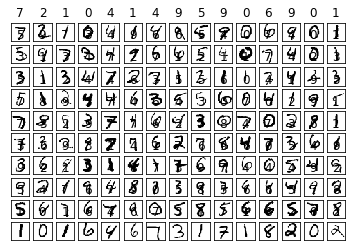

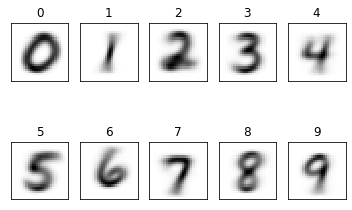

In [3]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "/content/drive/My Drive/Classroom/Machine Learning (1) 2020-1/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()


In [0]:
#!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
#!pip install cupy-cuda80



In [0]:
import cupy as cp

def one_hot(y):
  oneHotY = np.zeros((10, len(y)))
  for i in range(len(y)):
    oneHotY[y[i]][i] = 1
  return oneHotY


X_train = cp.asarray(list_image[:,:6000])
X_test  = cp.asarray(list_image[:,6000:])
y_train_index = cp.asarray(list_label[:6000])
y_test_index = cp.asarray(list_label[6000:])
y_train = cp.asarray(one_hot(list_label[:6000]))
y_test  = cp.asarray(one_hot(list_label[6000:]))

$J(\theta) = {1 \over M} \sum (l*log(h) - (1-l) log(1-h))$

$\theta_i = \theta_i - \alpha( \sum{(\sigma - Label)*x_i} )$

 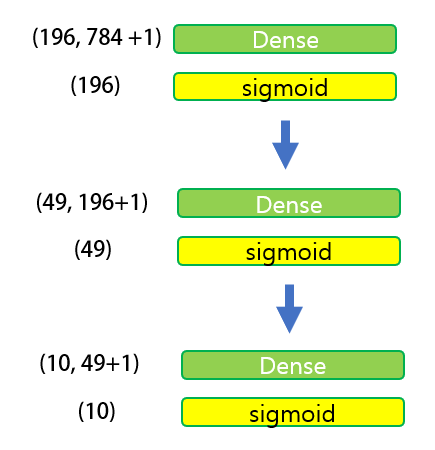



In [0]:
# Utilities

def loss_acc(X, y,y_index):
  H = forward(X)
  v = cp.sum(-cp.multiply(y, cp.log(H)) - cp.multiply(1-y, cp.log(1-H)))
  
  w = cp.argmax(H, axis=0)
  w = cp.sum(cp.equal(w, y_index))
  return (v, w/H.shape[1]*100)


In [0]:
# Shapes
input_size  = 784 
layer1_size = 196 
layer2_size = 49 
output_size = 10

# Weights
layer1 = cp.asarray(np.random.normal(0,1,(layer1_size, input_size+1 )))   # With bias
layer2 = cp.asarray(np.random.normal(0,1,(layer2_size, layer1_size+1)))  # With bias
outlay = cp.asarray(np.random.normal(0,1,(output_size, layer2_size+1)))  # With bias

# stores
loss_train = []
loss_test  = []
acc_train  = []
acc_test   = []

In [0]:
# Functions


lr_c = 0.001

def sigmoid(x):
  return 1/(1+cp.exp(-x))


def forward(x):
    global outlay, layer1, layer2
    # Layer 1

    output = cp.concatenate((x, cp.ones((1, len(x[0])))), axis=0)
    output = layer1.dot(output) 
    output = sigmoid(output)

    # Layer 2
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)   
    output = layer2.dot(output)
    output = sigmoid(output)
    
    # Output layer
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)
    output = outlay.dot(output)
    output = sigmoid(output)

    return output

def train(x, y):
    global outlay, layer1, layer2, lr, lr_c
    lr_c+=1
    lr = 1/(lr_c+10)

   # Layer 1
    output = cp.concatenate((x, cp.ones((1, len(x[0])))), axis=0)
    value1 = output
    output = cp.dot(layer1, output)
    output = sigmoid(output)
    sigval1 = output

    # Layer 2
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)   
    value2 = output
    output = cp.dot(layer2, output)
    output = sigmoid(output)
    sigval2 = output

    
    # Output layer
    output = cp.concatenate((output, cp.ones((1,len(output[0])))), axis=0)
    value3 = output
    output = cp.dot(outlay, output)
    output = sigmoid(output)

    # Backward
    temp1 = cp.dot(output - y, value3.T)/value3.shape[0]
    outlay -= lr* temp1

    # Value2 -->
    a = cp.multiply(sigval2, (1-sigval2))
    b = value2
    temp2 = cp.dot(a,b.T)
    tt2 = cp.sum(temp1, axis=0)[:-1]
    tt2 = cp.broadcast_to(tt2,(197,49)).T
    back2 = cp.multiply(tt2 , temp2)

    layer2 -= lr* temp2

    # Value1 -->
    c = cp.multiply(sigval1, (1-sigval1))
    d = value1
    temp3 = cp.dot(c,d.T)
    tt3 = cp.sum(temp2, axis=0)[:-1]
    tt3 = cp.broadcast_to(tt3, (785,196))
    layer1 -= lr* temp3

    return 


In [0]:
train(X_train, y_train)

In [0]:
COUNT = 100000
PRINT = COUNT//10

for k in range(0, COUNT+1):
  train(X_train, y_train)

  a,b = loss_acc(X_train, y_train, y_train_index)
  c,d = loss_acc(X_test, y_test, y_test_index)
  loss_train.append(a)
  loss_test.append(c)
  acc_train.append(b)
  acc_test.append(d)
  if k%PRINT ==0:
    print(f"{k*100//COUNT:3d} {loss_train[-1]}")
  

  0 19492.271946699046
 10 19492.271946657682
 20 19492.27194664846
 30 19492.271946643974
 40 19492.271946641213
 50 19492.27194663929
 60 19492.271946637855
 70 19492.27194663675
 80 19492.27194663586
 90 19492.27194663511


## II. Results

1. Plot the loss curve

plot the training loss at every iteration of gradient descent using the training data in blue color (the first 6,000 images) [5pt]

plot the testing loss at every iteration of gradient descent using the testing data in red color (the rest 4,000 images) [5pt]

the both curves should be presented in one figure



Text(0.5, 1.0, 'Loss Curve')

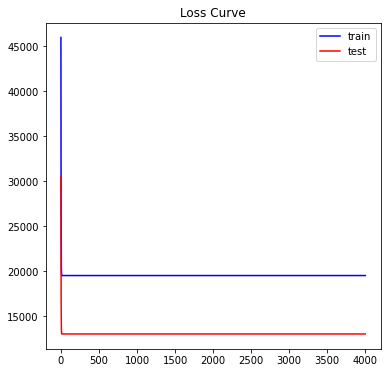

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(loss_train, color='b')
plt.plot(loss_test,  color='r')
plt.legend(['train', 'test'])
plt.title('Loss Curve')

2. Plot the accuracy curve

plot the training accuracy (%) at every iteration of gradient descent using the training data in blue color (the first 6,000 images) [5pt]

plot the testing accuracy (%) at every iteration of gradient descent using the testing data in red color (the rest 4,000 images) [5pt]

the both curves should be presented in one figure

Text(0.5, 1.0, 'Accuracy Curve')

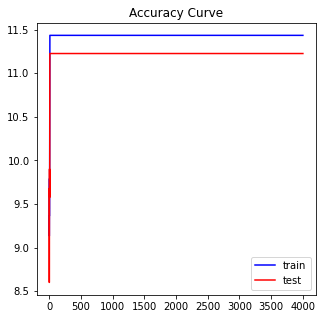

In [159]:
plt.figure(figsize=(5,5))
plt.plot(acc_train, color='b')
plt.plot(acc_test , color='r')
plt.legend(['train', 'test'])
plt.title('Accuracy Curve')

3. Plot the accuracy value

print the final training accuracy (%) using the training data (the first 6,000 images) [2pt]

print the final testing accuracy (%) using the testing data (the rest 4,000 images) [2pt]

In [160]:
from termcolor import colored

print(colored(f"Final Training Accuracy Of Train Data : {float(acc_train[-1]):.1f}%", 'red'))
print(colored(f"Final Training Accuracy Of Test  Data : {float(acc_test[-1]):.1f}%", 'blue'))

Final Training Accuracy Of Train Data : 11.4%
Final Training Accuracy Of Test  Data : 11.2%


4. Plot the classification example

present 10 correctly classified testing images with their labels at the title of each sub-figure in 2x5 array [5pt]

present 10 misclassified testing images with their misclassified labels at the title of each sub-figure in 2x5 array [5pt]